# 04 – Machine Learning Classifier for CD44 Phenotype

📓 This notebook:

- Uses the top differentially expressed genes as features  
- Trains a Random Forest classifier to distinguish **CD44_high** vs **CD44_low**  
- Evaluates performance using **leave-one-out cross-validation (LOOCV)**  
- Computes the **ROC curve** and **AUC**  
- Generates a **confusion matrix** and **feature importance plot**  
- Saves predictions and feature importances into `results/`  

This analysis demonstrates whether transcriptomic signatures can reliably
predict CD44 phenotype using a supervised learning approach.


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

# ---------------------------------------------------------------------
# Load processed data and results generated in previous notebooks
# ---------------------------------------------------------------------
BASE_DIR = Path("..").resolve()
DATA_PROCESSED = BASE_DIR / "data" / "processed"
RESULTS_DIR = BASE_DIR / "results"
FIG_DIR = BASE_DIR / "figures"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load processed counts & metadata
counts = pd.read_csv(DATA_PROCESSED / "GSE113660_counts.csv", index_col=0)
metadata = pd.read_csv(DATA_PROCESSED / "GSE113660_metadata.csv")

# Load DESeq2 results
res_df = pd.read_csv(RESULTS_DIR / "GSE113660_deseq2_results.csv", index_col=0)

print("Counts:", counts.shape)
print("Metadata:", metadata.shape)
print("DE results:", res_df.shape)
metadata.head()


Counts: (33572, 9)
Metadata: (9, 2)
DE results: (22115, 6)


,sample,condition
0,SJRHB046412_C1,unsorted
1,SJRHB046412_C2,CD44_high
2,SJRHB046412_C3,CD44_low
3,SJRHB046412_C4,CD44_low
4,SJRHB046412_C5,CD44_low


In [2]:
# ---------------------------------------------------------------------
# Align metadata with columns of the count matrix and subset samples
# ---------------------------------------------------------------------
metadata = metadata.set_index("sample")
metadata = metadata.loc[counts.columns]

# Keep only CD44_high / CD44_low
mask = metadata["condition"].isin(["CD44_high", "CD44_low"])

counts_sub = counts.loc[:, mask.values]
metadata_sub = metadata.loc[mask.values]

print("Filtered counts:", counts_sub.shape)
print(metadata_sub)


Filtered counts: (33572, 6)
                condition
SJRHB046412_C2  CD44_high
SJRHB046412_C3   CD44_low
SJRHB046412_C4   CD44_low
SJRHB046412_C5   CD44_low
SJRHB046412_C6  CD44_high
SJRHB046412_C7  CD44_high


In [4]:
# ---------------------------------------------------------------------
# Select top 50 DE genes (lowest adjusted p-values)
# ---------------------------------------------------------------------
df_res = res_df.copy().dropna(subset=["padj"])
df_res = df_res.sort_values("padj")

# Top 50 genes
top50_genes = df_res.head(50).index.tolist()

# Keep only genes that exist in the filtered count matrix
top50_genes = [g for g in top50_genes if g in counts_sub.index]
len(top50_genes), top50_genes[:5]


(50, ['ADAMTS15', 'FSTL1', 'GRID2', 'LMO7', 'ELL2'])

In [5]:
# ---------------------------------------------------------------------
# Construct feature matrix (X) and labels (y)
# ---------------------------------------------------------------------
counts_top50 = counts_sub.loc[top50_genes]

# Log-transform for stability
X = np.log1p(counts_top50.T)    # shape: (samples, genes)

# Labels: 1 = CD44_high, 0 = CD44_low
y = metadata_sub["condition"].map({"CD44_low": 0, "CD44_high": 1})

print("X shape:", X.shape)
print("y:", y.values)


X shape: (6, 50)
y: [1 0 0 0 1 1]


In [6]:
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------------------
# Standardize features before ML
# ---------------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier

# ---------------------------------------------------------------------
# Leave-One-Out Cross-Validation (LOOCV)
# ---------------------------------------------------------------------
loo = LeaveOneOut()
y_true = []
y_pred = []
y_proba = []

model = RandomForestClassifier(
    n_estimators=500,
    random_state=42
)

for train_idx, test_idx in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)

    # Predicted class
    pred = model.predict(X_test)
    y_pred.extend(pred)

    # Probability of CD44_high
    proba = model.predict_proba(X_test)[:, 1]
    y_proba.extend(proba)

    y_true.extend(y_test)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_proba = np.array(y_proba)

print("True labels:   ", y_true)
print("Predicted:     ", y_pred)
print("Probabilities: ", np.round(y_proba, 3))


True labels:    [1 0 0 0 1 1]
Predicted:      [1 0 0 0 1 1]
Probabilities:  [0.93  0.174 0.09  0.09  0.92  0.904]


In [8]:
# ---------------------------------------------------------------------
# Save LOOCV predictions to CSV for documentation
# ---------------------------------------------------------------------
pred_df = pd.DataFrame({
    "sample": metadata_sub.index,
    "true_label": y_true,
    "pred_label": y_pred,
    "proba_CD44_high": y_proba
})

out_pred_path = RESULTS_DIR / "ml_predictions_loocv.csv"
pred_df.to_csv(out_pred_path, index=False)
out_pred_path


PosixPath('/Users/melikagr/bioinformatics-projects/GSE113660-cd44-rnaseq-analysis/results/ml_predictions_loocv.csv')

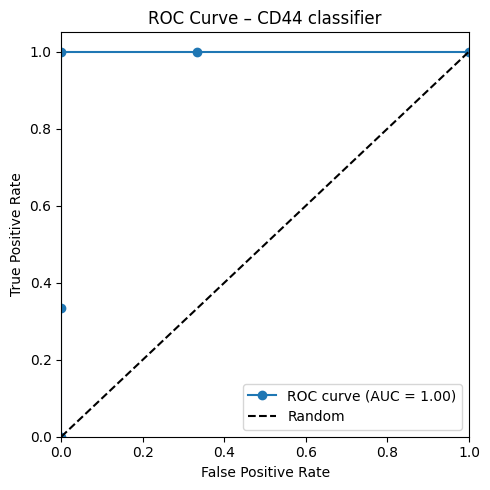

PosixPath('/Users/melikagr/bioinformatics-projects/GSE113660-cd44-rnaseq-analysis/figures/roc_CD44_classifier.png')

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# ---------------------------------------------------------------------
# ROC Curve and AUC
# ---------------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, marker="o", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – CD44 classifier")
plt.legend(loc="lower right")
plt.tight_layout()

roc_path = FIG_DIR / "roc_CD44_classifier.png"
plt.savefig(roc_path, dpi=300)
plt.show()

roc_path


Classification report:
              precision    recall  f1-score   support

    CD44_low       1.00      1.00      1.00         3
   CD44_high       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



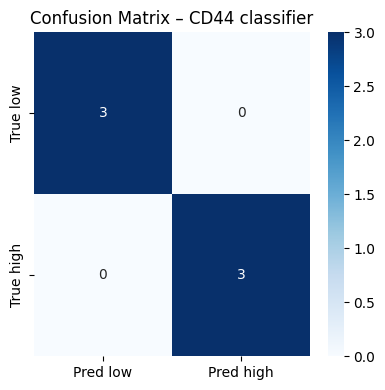

PosixPath('/Users/melikagr/bioinformatics-projects/GSE113660-cd44-rnaseq-analysis/figures/cm_CD44_classifier.png')

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ---------------------------------------------------------------------
# Confusion Matrix and Classification Report
# ---------------------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=["CD44_low", "CD44_high"]))

plt.figure(figsize=(4,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred low", "Pred high"],
    yticklabels=["True low", "True high"]
)
plt.title("Confusion Matrix – CD44 classifier")
plt.tight_layout()

cm_path = FIG_DIR / "cm_CD44_classifier.png"
plt.savefig(cm_path, dpi=300)
plt.show()

cm_path


In [11]:
# ---------------------------------------------------------------------
# Feature Importance (Top 15 most informative genes)
# ---------------------------------------------------------------------
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[-15:]  # 15 ژن برتر

top_genes_ordered = np.array(top50_genes)[indices]

feat_imp_df = pd.DataFrame({
    "gene": top_genes_ordered,
    "importance": importances[indices]
}).sort_values("importance", ascending=False)

feat_imp_path = RESULTS_DIR / "feature_importance_randomforest.csv"
feat_imp_df.to_csv(feat_imp_path, index=False)
feat_imp_path


PosixPath('/Users/melikagr/bioinformatics-projects/GSE113660-cd44-rnaseq-analysis/results/feature_importance_randomforest.csv')

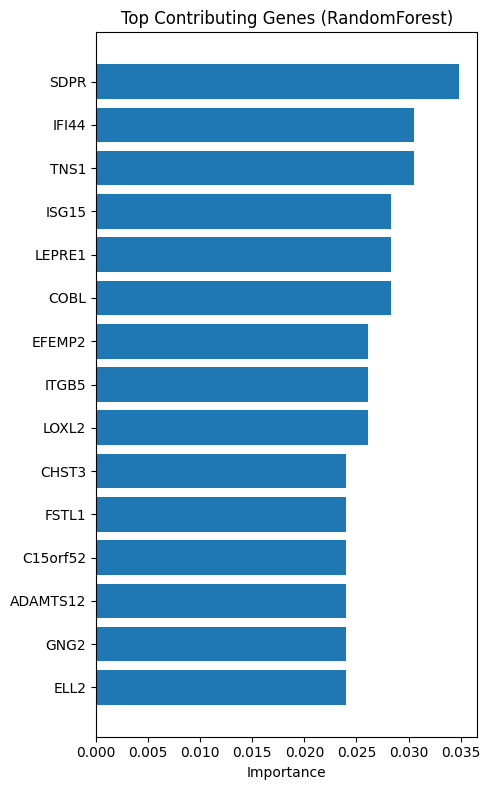

PosixPath('/Users/melikagr/python-practice/brca/figures/feature_importance_randomforest.png')

In [11]:
plt.figure(figsize=(5,8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), top_genes_ordered)
plt.xlabel("Importance")
plt.title("Top Contributing Genes (RandomForest)")
plt.tight_layout()

fi_fig_path = FIG_DIR / "feature_importance_randomforest.png"
plt.savefig(fi_fig_path, dpi=300)
plt.show()

fi_fig_path
